<a href="https://colab.research.google.com/github/LuigiPagani/ROM-with-POD-and-DL/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*
!pip install pyDOE



  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=fcf0ca7370faa7baa5d8dd172575be6582689de5ccb6184b65e4b9890b96aaf5
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


**Preliminaries**

In [152]:
import numpy as np
from fenics import *
from pyDOE import lhs
from scipy.sparse.linalg import spsolve
import dlroms.fespaces as fe
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from convdiff import Stokes_solver
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1) # FE space for u (chemical concentration)
bspace = fe.space(mesh, "CG", 1, scalar = False, bubble = True) # FE space for b (transport field)

def Convdiff_solver(w1, w2, steps = 50, dt = 5e-4):
    # Assembling relevant operators
    v1, v2 = TrialFunction(Vh), TestFunction(Vh)
    M = sp.csr_matrix(assemble(v1*v2*dx).array()) # mass matrix
    S = sp.csr_matrix(assemble(inner(grad(v1), grad(v2))*dx).array()) # stiffness (diffusion) matrix

    b = Stokes_solver(w1, w2)
    b1 = Stokes_solver(1,0)
    b2 = Stokes_solver(0,1)
    bf = fe.asvector(b, bspace)
    bf1 = fe.asvector(b1, bspace)
    bf2 = fe.asvector(b2, bspace)

    B = sp.csr_matrix(assemble(inner(bf, grad(v1))*v2*dx).array()) # transport matrix
    B1 = sp.csr_matrix(assemble(inner(bf1, grad(v1))*v2*dx).array())
    B2 = sp.csr_matrix(assemble(inner(bf2, grad(v1))*v2*dx).array())

    # Time-stepping scheme
    def FOMstep(u0, dt, b):
        A = M + dt*S + 1000*dt*B
        F = M @ u0
        return spsolve(A, F)

    # Initial condition
    x, y = fe.coordinates(Vh).T
    u0 = np.exp(-16*(x-0.5)**2 -16*(y-0.5)**2)

    # Initialize storage for solution as a NumPy array
    u = np.empty((len(u0), steps + 1))
    u[:, 0] = u0

    # Time loop
    for n in range(steps):
        u[:, n + 1] = FOMstep(u[:, n], dt, b)

    return u, M, S, B, B1, B2


# Define the parameter space
n_samples = 100  # Reduced number of samples
parameter_ranges = [np.linspace(0, 10, 100), np.linspace(0, 10, 100)]  # Define parameter ranges

# Generate Latin Hypercube Samples
lhs_samples = lhs(2, samples=n_samples, criterion='center')  # 2 for two parameters, criterion 'center' for centered samples
params = np.array([parameter_ranges[0][((lhs_samples[:, i] * 99).astype(int))] for i in range(2)]).T

# Generate snapshots
snapshots = []  # Initialize an empty list to store matrices
for w1, w2 in params:
    u, M, S, B,B1,B2 = Convdiff_solver(w1, w2)  # Get the time series data and matrices from the solver
    u = u.reshape(961, -1)  # Reshape u to have consistent dimensions
    if len(snapshots) == 0:
        snapshots = u  # If snapshots is empty, initialize it with the first u
    else:
        snapshots = np.hstack((snapshots, u))  # Stack u horizontally with the existing snapshots




**Matrix Assembly**

In [165]:
from scipy.linalg import svd

U, s, Vt = svd(snapshots, full_matrices=False)


# Now you can apply SVD or any other analysis you wish to this giant matrix
from scipy.linalg import svd
U, s, Vt = svd(snapshots, full_matrices=False)

energy = np.cumsum(s**2) / np.sum(s**2)

# Determine number of modes to retain 99% of energy
n_modes = np.searchsorted(energy, 0.99)

V = U[:, :n_modes]



mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1) # FE space for u (chemical concentration)
bspace = fe.space(mesh, "CG", 1, scalar = False, bubble = True) # FE space for b (transport field)

from scipy.sparse import csr_matrix

# Assuming we have a function to assemble FOM matrices
w1 = 5
w2 = 5
u, M_fom, S_fom, B_fom,B1_fom,B2_fom = Convdiff_solver(w1, w2, steps = 50, dt = 5e-4)

M_rb = V.T @ M_fom @ V
S_rb = V.T @ S_fom @ V
B_rb = V.T @ B_fom @ V
B1_rb = V.T @ B1_fom @ V
B2_rb = V.T @ B2_fom @ V

# Calculate the linear combination of B1 and B2 using the given weights
B_combined_fom = w1 * B1_fom + w2 * B2_fom

# Compute the difference between B_fom and the weighted linear combination
difference_fom = B_fom - B_combined_fom
print(V.shape)




(961, 5)


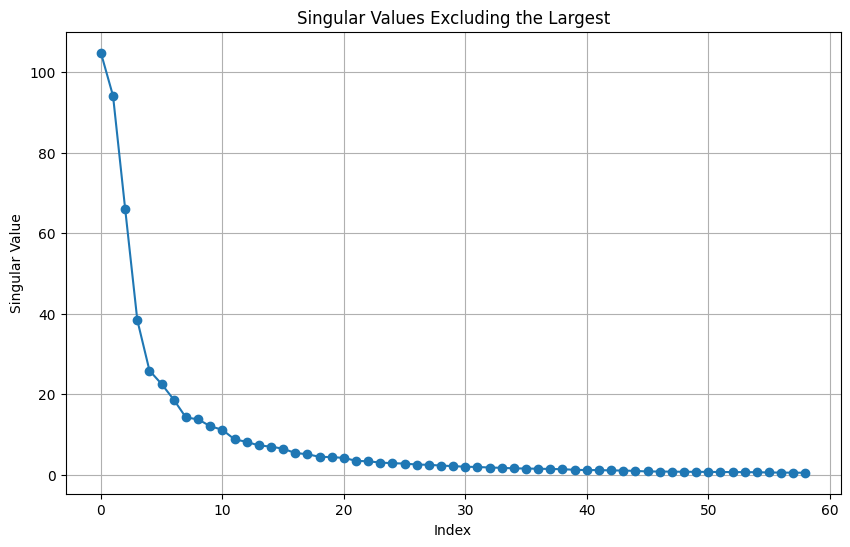

In [166]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 's' contains your singular values from the SVD
singular_values = s[1:60]  # Exclude the largest singular value

# Plotting the remaining singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, marker='o')
plt.title('Singular Values Excluding the Largest')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()


**Time Stepping**
Fixes Pending


In [167]:

def RBstep(u_rb, dt):
    # Assuming M_rb, S_rb, B1_rb, B2_rb, w1, w2 are defined elsewhere and are numpy arrays
    A_rb = M_rb + dt * S_rb + 1000 * dt * (w1 * B1_rb + w2 * B2_rb)
    F_rb = M_rb @ u_rb
    return np.linalg.solve(A_rb, F_rb)

# Assuming 'V' is the matrix containing the left singular vectors (reduced basis vectors)
# and 'u' contains the simulation snapshots from the Full Order Model (FOM).

u0_rb = V.T @ u[:,0]  # Project the initial condition onto the reduced basis

# Number of time steps based on final time T and time step dt
T_final = 0.025
dt = 5e-4
n_steps = int(T_final / dt)

# Initialize storage for RB solution as a NumPy array
u_rb = np.zeros((V.shape[1], n_steps + 1))  # V.shape[1] is the number of reduced basis vectors
u_rb[:, 0] = u0_rb

# Time-stepping loop for the RB method
for n in range(n_steps):
    u_rb[:, n + 1] = RBstep(u_rb[:, n], dt)

# Optionally, convert back to full space for visualization or further analysis
u_rb_full = V @ u_rb  # This results in each column representing the solution at a time step

# If you need to transpose for further processing:

**Error Calculation**

In [168]:

# Assuming 'u' is the original full matrix, and 'u_rb_full' is the reconstructed matrix after reduction and back-projection

error_vector = u - u_rb_full

# Calculate the norm of the difference (numerator of the relative error)
error_norm = np.linalg.norm(error_vector, axis=0)  # Since we transposed, use axis=0 to operate along columns

# Calculate the norm of the original vector (denominator of the relative error)
u_norm = np.linalg.norm(u, axis=0)  # Norm of each column in the original matrix

# Calculate the relative error for each column
relative_error = error_norm / u_norm

# Calculate the average of the relative errors
average_relative_error = np.mean(relative_error)

print("Average Relative Error:", average_relative_error)


Average Relative Error: 0.15238161212639564
